In [26]:
from os import listdir
from os.path import isfile, join
# from Utils import Load, Write
import pandas as pd
import numpy as np
from scipy import stats
import math
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import cm
# import plotly.plotly as py
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
from pop_calcs import *
from pop_organize import *
from skbio.diversity.alpha import shannon, simpson, berger_parker_d
import time

In [20]:
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot

In [18]:
def get_sample_data(sample_name, generate_dfs): 
## this function generates dfs (general, only productive and only non productive) for each sample, and save
## as pickles. alternatively, it loads these dfs from pickles. 
    
    print 'getting sample data...'
    
    if generate_dfs:
        sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)  
        sample_df_prod = sample_df[sample_df['sequenceStatus'] == 'In']
        sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']
        
        pickle.dump(sample_df, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_%s' %sample_name, "wb"))
        pickle.dump(sample_df_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_%s' %sample_name, "wb"))
        pickle.dump(sample_df_non_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_%s' %sample_name, "wb"))
    else:
        sample_df= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_%s' %sample_name,"rb" ))
        sample_df_prod= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_%s' %sample_name,"rb" ))
        sample_df_non_prod= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_%s' %sample_name,"rb" ))
    
    print 'finished getting sample data'
    return sample_df, sample_df_prod, sample_df_non_prod

#_________________________________________________________________

In [59]:
def rarefaction_calc(sample_name, df_list, column_name,sampling_interval):
    
    print ('rarefaction analysis for sample %s' %sample_name)

    n=0
    all_data=[]
    all_seqs=[]
    all_seq_popped=[]
    popped_list_lengths=[]
    '''
    the following loop generate three lists:
    (1) all_seqs list=contains lists of all uniqe sequences in each df contains within the df_list.
    (2) all_data list=contains lists of reads/templates number for each sequence in the all_seq_list
    (3) all_seq_popped list=contains list of popped squences lists, in which each sequence appears the number
    of times indicated by the number of reads/ template
    ***** note that each of the  lists is mata-list containing n lists of the data*******
    '''
    for n in range(len(df_list)):
        data=list(df_list[n][column_name])
        df_list[n]=df_list[n].set_index('nucleotide')
        seq=[str(i) for i in list(df_list[n].index)]
        all_data.append(data)
        all_seqs.append(seq)
        seq_popped=[]
        for i in range(0,len(seq)):
            for j in range(0,data[i]):
                seq_popped.append(seq[i])        
        all_seq_popped.append(seq_popped)
        popped_list_lengths.append(len(seq_popped))       
        n=n+1
     
     
    max_samp_size=max(popped_list_lengths)
    print('the maximal sample size will be: %s' %max_samp_size)
    samp_size=range(0,max_samp_size,sampling_interval)
        
    n=0
    n_samp_seq_all=[]
    last_values=[]
    for popped in all_seq_popped:
        n_samp_seq=[]
        for size in samp_size:
            if size<=len(popped): ## if the sample size is larger than the amount of
                                  ## sequences in the sample, do not employ random sampling
                rand_seq=np.random.choice(popped, size, replace=False)
                seq_n=len(set(rand_seq))
                n_samp_seq.append(seq_n)
            else:
                n_samp_seq.append(np.nan)
 ##since it is time consuming to generate theses lists, save them as pickles and next time load the pickles
## (comment/uncomment each of the next couple of lines:):          
        pickle.dump(n_samp_seq, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/n_samp_seq_%s_%s.p' %(n, sample_name),"wb" ))
        n_samp_seq_all.append(pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/n_samp_seq_%s_%s.p' %(n, sample_name),"rb" )))
        last_values.append(n_samp_seq[-1])
        
        n=n+1
    last_values=[x for x in last_values if str(x) != 'nan']
    ymax_rare=max(last_values)
    print('last values list is %s' %last_values)
    print('ymax for rarefaction plot is %s' %ymax_rare)
    print ('finished rarefaction analysis for sample %s...' %sample_name)
   
    return samp_size,max_samp_size, n_samp_seq_all, ymax_rare      

#------------------------------------------------------------------------------------------------------------




   
def rarefaction_plot(ax, sample_name, data, names, colors, samp_size, max_samp_size,ymax_rare):
    '''
    this function generates rarefaction graphs for one or more datasets at the same time.
    the datasets can be generated by the function rarefaction_calc. 
    *** the data is a meta-list that can contains several lists of rarefaction values, but they must be generated
    using the same samp_size list***
    input:
    sample_name
    data - see above (the udea is that in each sample size, the list of all sequences in the sample 
    is randomly samples, and the number of unique clones sampled is indicated).
    names corresponding names for the lists in 'data' rarefaction graphs.
    ***need to insert at least name1*** 
    colors: corresponding names for the lists in 'data' rarefaction graphs.
    ***need to insert at least color1***
    samp_size: list of increasing sample sizes, corresponding to the values in the data sets
    max_samp_size: the length of the shorter list among the dataset
    y_max - the maximal value in all data sets together
    ax - the number of subplot in the original image   
    '''
    
    
    print 'plotting rarefaction graphs'
    if ax is None:
        ax = plt.gca()
    curves=[]
    for i in range(len(data)):
        curve=ax.plot(samp_size,data[i],label=names[i],color=colors[i])
        curves.append(curve)
  
    ax.set_title('%s' %sample, fontsize=12)
    ax.set_xlabel('Sample Size',fontsize=9)
    ax.set_ylabel('Number of unique sequences',fontsize=9)
    fold=np.log10(max_samp_size)
    fold_floor=int(math.floor(fold))
    xticks=range(0,roundup(max_samp_size,10**fold_floor)+10**fold_floor,10**fold_floor)
    yticks=range(0,roundup(ymax_rare,10000)+10000,10000)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticks, rotation=45, fontsize=8)
    ax.set_yticklabels(yticks, fontsize=8)
    ax.legend(loc='best')
    ax.set_xlim(0, roundup(max_samp_size,10000))
    #ax.set_ylim(0, roundup(ymax_rare,10000))
    print 'Finished plotting rarefaction graphs'
    return curves

#-------------------------------------------------------------------------------------------------

def rarefaction_plot_zoom(ax, sample_name, data, names, colors, samp_size, max_samp_size,ymax_rare,xmax,ymax):
    '''
    this function generates rarefaction graphs for one or more datasets at the same time.
    the datasets can be generated by the function rarefaction_calc. 
    *** the data is a meta-list that can contains several lists of rarefaction values, but they must be generated
    using the same samp_size list***
    input:
    sample_name
    data - see above (the udea is that in each sample size, the list of all sequences in the sample 
    is randomly samples, and the number of unique clones sampled is indicated).
    names corresponding names for the lists in 'data' rarefaction graphs.
    ***need to insert at least name1*** 
    colors: corresponding names for the lists in 'data' rarefaction graphs.
    ***need to insert at least color1***
    samp_size: list of increasing sample sizes, corresponding to the values in the data sets
    max_samp_size: the length of the shorter list among the dataset
    y_max - the maximal value in all data sets together
    ax - the number of subplot in the original image   
    '''
    
    
    print 'plotting rarefaction graphs'
    if ax is None:
        ax = plt.gca()
    curves=[]
    for i in range(len(data)):
        curve=ax.plot(samp_size,data[i],label=names[i],color=colors[i])
        curves.append(curve)
  
    ax.set_title('%s' %sample, fontsize=12)
    ax.set_xlabel('Sample Size',fontsize=9)
    ax.set_ylabel('Number of unique sequences',fontsize=9)
    fold=np.log10(max_samp_size)
    fold_floor=int(math.floor(fold))
    xticks=range(0,roundup(max_samp_size,10**fold_floor)+10**fold_floor,10**fold_floor)
    yticks=range(0,roundup(ymax_rare,10000)+10000,10000)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticks, rotation=45, fontsize=8)
    ax.set_yticklabels(yticks, fontsize=8)
    #ax.legend(loc='best')
    ax.set_xlim(xmax-10000, xmax)
    ax.set_ylim(ymax-10000, ymax)
    print 'Finished plotting rarefaction graphs'
    return curves

rarefaction analysis for sample 139
the maximal sample size will be: 65176
last values list is [43630]
ymax for rarefaction plot is 43630
finished rarefaction analysis for sample 139...
plotting rarefaction graphs
Finished plotting rarefaction graphs
rarefaction analysis for sample 207
the maximal sample size will be: 47311
last values list is [29619, 29772]
ymax for rarefaction plot is 29772
finished rarefaction analysis for sample 207...
plotting rarefaction graphs
Finished plotting rarefaction graphs
rarefaction analysis for sample 415
the maximal sample size will be: 67730
last values list is [35102]
ymax for rarefaction plot is 35102
finished rarefaction analysis for sample 415...
plotting rarefaction graphs
Finished plotting rarefaction graphs
rarefaction analysis for sample 418
the maximal sample size will be: 35650
last values list is [23317]
ymax for rarefaction plot is 23317
finished rarefaction analysis for sample 418...
plotting rarefaction graphs
Finished plotting rarefact

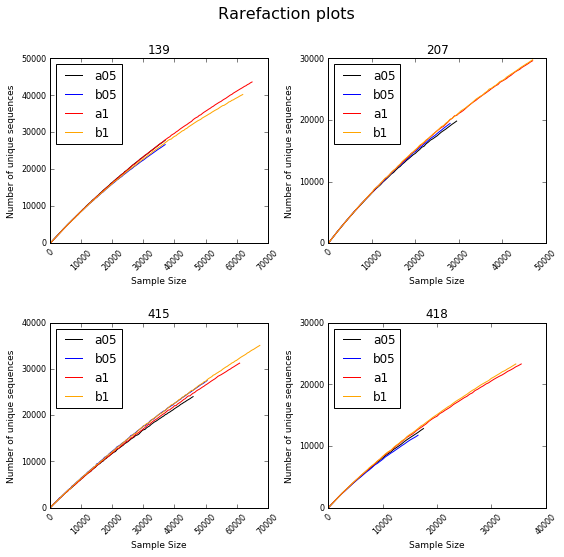

In [60]:
fig1=plt.figure(figsize=(8,8))
plt.suptitle ('Rarefaction plots', fontsize=16)
ax1 =  plt.subplot2grid((2,2), (0,0)) 
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1, 0))
ax4 = plt.subplot2grid((2,2), (1, 1))
ax_list=[ax1,ax2,ax3,ax4]
for n,sample in enumerate(sample_list):
       
    
    
    a05_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/BD%sa_05ug.tsv" % sample)
    b05_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/BD%sb_05ug.tsv" % sample)
    a1_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/BD%sa_1ug.tsv" % sample)
    b1_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/BD%sb_1ug.tsv" % sample)
    samp_size,max_samp_size, n_samp_seq_all, ymax_rare=rarefaction_calc(sample, [a05_df, b05_df, a1_df,b1_df],column_name='count (templates/reads)',sampling_interval=500)   
   
    rarefaction_plot(ax=ax_list[n], sample_name=sample, data=n_samp_seq_all, names=['a05', 'b05', 'a1','b1'], colors=['black', 'blue','red','orange'], samp_size=samp_size, max_samp_size=max_samp_size,ymax_rare=ymax_rare)
plt.subplots_adjust(left=0.09,bottom=0.11, right=0.95, top=0.89, wspace=0.28,hspace=0.43)
with PdfPages('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Images/realData_replicationComparison_rarefaction') as pdf:
    pdf.savefig(fig1)
pdf.close
plt.show()

rarefaction analysis for sample 139
the maximal sample size will be: 65176
last values list is [43646]
ymax for rarefaction plot is 43646
finished rarefaction analysis for sample 139...
plotting rarefaction graphs
Finished plotting rarefaction graphs
rarefaction analysis for sample 207
the maximal sample size will be: 47311
last values list is [29627, 29789]
ymax for rarefaction plot is 29789
finished rarefaction analysis for sample 207...
plotting rarefaction graphs
Finished plotting rarefaction graphs
rarefaction analysis for sample 415
the maximal sample size will be: 67730
last values list is [35133]
ymax for rarefaction plot is 35133
finished rarefaction analysis for sample 415...
plotting rarefaction graphs
Finished plotting rarefaction graphs
rarefaction analysis for sample 418
the maximal sample size will be: 35650
last values list is [23318]
ymax for rarefaction plot is 23318
finished rarefaction analysis for sample 418...
plotting rarefaction graphs
Finished plotting rarefact

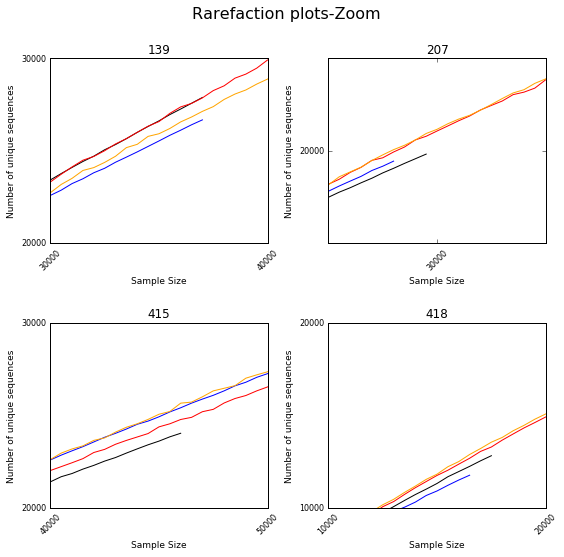

In [62]:
fig2=plt.figure(figsize=(8,8))
plt.suptitle ('Rarefaction plots-Zoom', fontsize=16)
ax1 =  plt.subplot2grid((2,2), (0,0)) 
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1, 0))
ax4 = plt.subplot2grid((2,2), (1, 1))
xlim_list=(40000, 35000, 50000, 20000)
ylim_list=(30000,25000,30000,20000)
ax_list=[ax1,ax2,ax3,ax4]
for n,sample in enumerate(sample_list):
       
    
    
    a05_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/BD%sa_05ug.tsv" % sample)
    b05_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/BD%sb_05ug.tsv" % sample)
    a1_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/BD%sa_1ug.tsv" % sample)
    b1_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/BD%sb_1ug.tsv" % sample)
    samp_size,max_samp_size, n_samp_seq_all, ymax_rare=rarefaction_calc(sample, [a05_df, b05_df, a1_df,b1_df],column_name='count (templates/reads)', sampling_interval=500)   
   
    rarefaction_plot_zoom(ax=ax_list[n], sample_name=sample, data=n_samp_seq_all, names=['a05', 'b05', 'a1','b1'], 
                          colors=['black', 'blue','red','orange'], samp_size=samp_size, max_samp_size=max_samp_size,
                          ymax_rare=ymax_rare, xmax=xlim_list[n], ymax=ylim_list[n])
plt.subplots_adjust(left=0.09,bottom=0.11, right=0.95, top=0.89, wspace=0.28,hspace=0.43)
with PdfPages('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Images/realData_replicationComparison_rarefaction_zoom') as pdf:
    pdf.savefig(fig2)
pdf.close
plt.show()

In [30]:
l=[np.nan, np.nan, 41143, 39316]

In [31]:
l_max=max(l)

In [32]:
print l_max

nan


In [33]:
cleanedList = [x for x in l if str(x) != 'nan']

In [35]:
print cleanedList

[41143, 39316]
